In [267]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import FTIR_functions as FTIR

np.set_printoptions(threshold=sys.maxsize)

In [268]:
def make_causal(x, y):
    x, y = np.array(x), np.array(y)
    y[x < 0] = 0
    return y
    

def convolve(array, xs, convol_func): # Convolves an array with a function. Uses the fft which requires xs to be evenly spaced. Fast and works with nd.
    assert array.shape == xs.shape, "All values in the array must have a corrisponding x value."
    convol_array = convol_func(xs)
    convol_FT = np.fft.fftn(convol_array, norm= "forward")
    FT = np.fft.fftn(array, norm= "forward")
    convolved_FT = FT *convol_FT
    convolved = np.fft.ifftn(convolved_FT, norm= "forward")
    return convolved

def convolve(array, xs, convol_func): # Convolves an array with a function. Uses numberical intergral which can be susceptible to floating point errors.
    assert len(array) == len(xs), "All values in the array must have a corrisponding x value."
    summation = np.zeros_like(xs, dtype= np.complex128)
    for n, y in enumerate(xs):
        convol_array = convol_func(xs-y)
        summation = summation + array[n]*convol_array
    sort = np.argsort(xs)
    unsort = np.argsort(sort)
    normalisation = np.diff(xs[sort], append= 2*xs[sort][-1] -xs[sort][-2]) # Extrapolate the last value.
    normalisation = normalisation[unsort] # When approximatating an intergral to the sum of many rectangles, we must find the area by multiplying by the width of the rectangles.
    return normalisation *summation

def hilbert_transform(array, xs):
    cauchy_kernel = lambda t: np.nan_to_num(1/(np.pi*t), nan=0, posinf=0, neginf=0) # replace all invalid values with 0
    return convolve(array, xs, cauchy_kernel) # We don't need the normalisation constant of 1/np.pi that you would find in a continuous integral because we have already applied the descrieteised normalisation.

In [269]:
array_length = 10000 #in pixels
central_wavenumber = 3e-3 #in pixels^-1
FWHM_wavenumber = 5e-4 #in pixels^-1

print(1/central_wavenumber) # effective wavelength in pixels

333.3333333333333


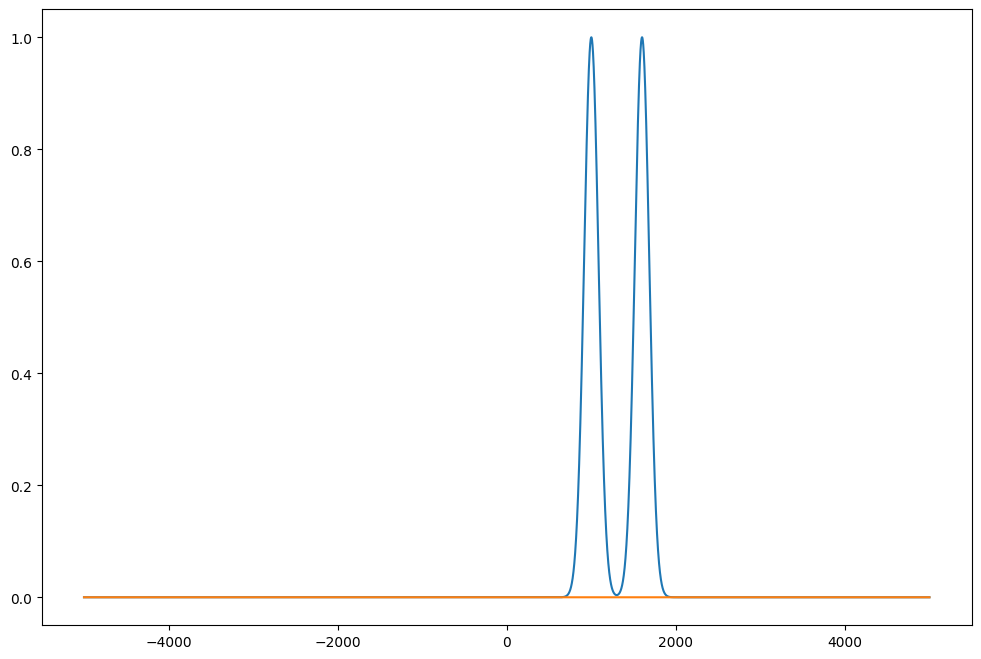

In [270]:
displacement = np.arange(array_length) - array_length//2
intensity = FTIR.gaussian(displacement, 1000, 200) +FTIR.gaussian(displacement, 1600, 200)

fig, axs = plt.subplots(1,1, figsize= (12,8))
axs.plot(displacement, intensity.real)
axs.plot(displacement, intensity.imag)

plt.show()

In [271]:
intensity = make_causal(displacement, intensity)
intensity = intensity.real

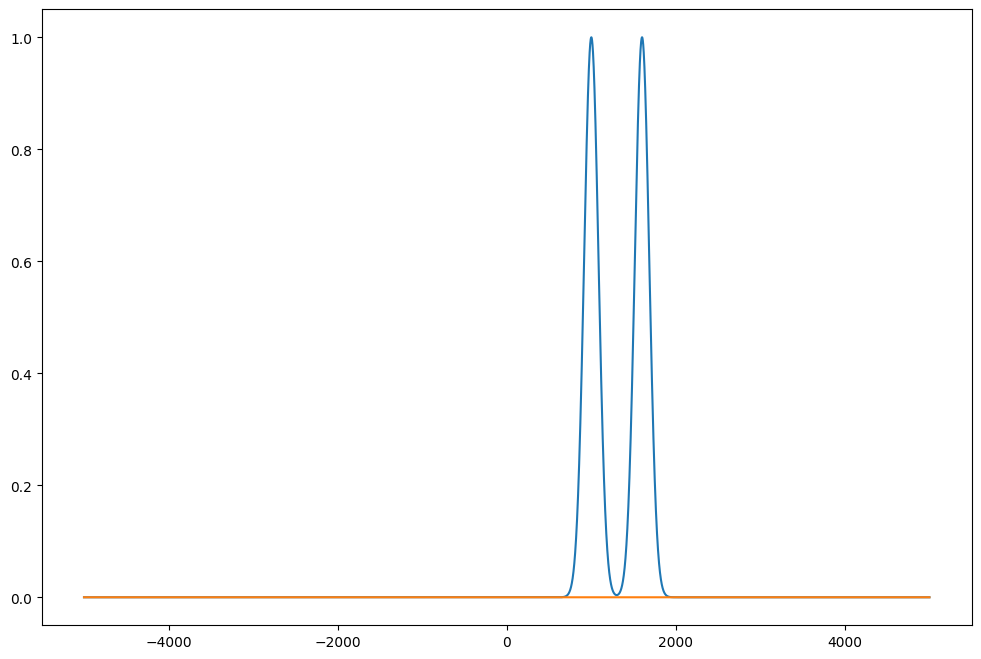

In [272]:
fig, axs = plt.subplots(1,1, figsize= (12,8))

axs.plot(displacement, intensity.real)
axs.plot(displacement, intensity.imag)

plt.show()

### Gerchberg-Saxon

In [274]:
def gerchberg_saxon(rho, initial_guess, iterations= 10000, tolerance= 0.01, beta= 1):
    array_length = len(initial_guess)

    #initialise loop
    IFFT0 = initial_guess # DO NOT COPY. np.copy, copy.copy and copy.deepcopy inexplicably break the gerchberg_saxon algorithm
    is_causal = np.zeros(array_length, dtype=bool)

    #begin loop
    for n in range(iterations):

        FT0 = np.fft.rfft(initial_guess)

        ## FOURIER DOMAIN CONSTRAINT
        phase = np.angle(FT0)
        FT1 = rho *np.exp(1j *phase)

        IFFT1 = np.fft.irfft(FT1, n= array_length)

        ## SUPPORT CONSTRAINT
        is_positive = np.angle(IFFT1) < tolerance
        #violates_constraint = np.logical_not(is_positive)
        is_causal[:array_length//2] = True
        is_causal[array_length//2:] = np.abs(IFFT1[array_length//2:]) < tolerance*np.max(np.abs(IFFT1[array_length//2:]))
        violates_constraint = np.logical_not(np.logical_and(is_positive, is_causal))

        ## Fienup's application of the support constraint
        IFFT0[~violates_constraint] = IFFT1[~violates_constraint]
        IFFT0[violates_constraint] = IFFT0[violates_constraint] -beta*IFFT1[violates_constraint]

    return np.angle(FT1)



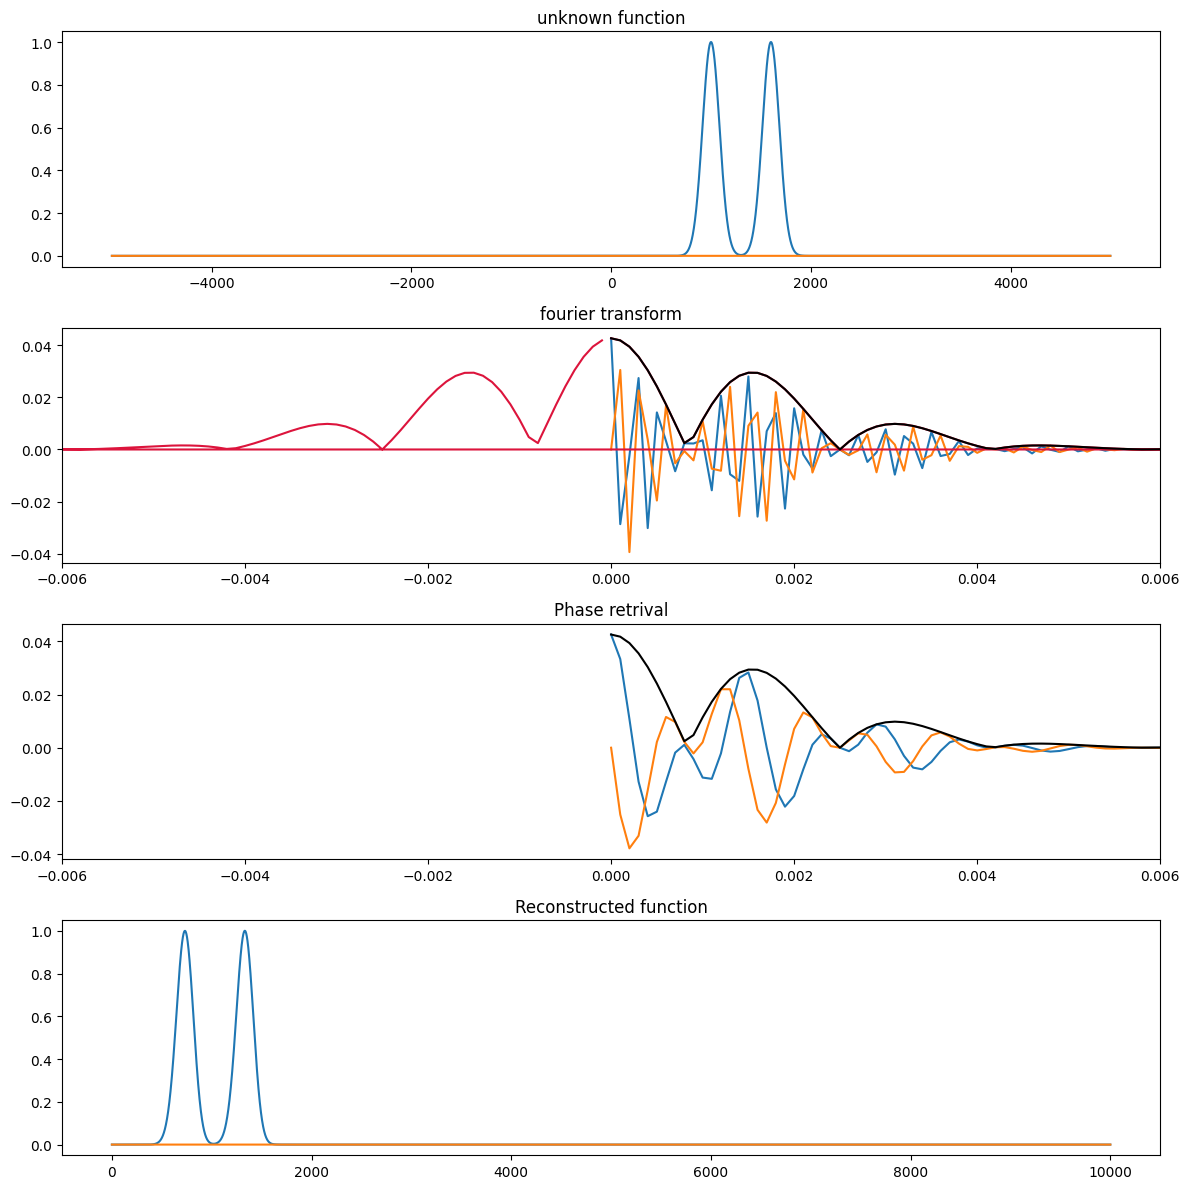

In [275]:
amplitudes = np.fft.rfft(intensity, norm= "forward") 
positive_wavenumbers = np.fft.rfftfreq(array_length, 1)
wavenumbers = np.fft.fftfreq(array_length, 1)

fig, axs = plt.subplots(4,1, figsize= (12,12))

axs[0].plot(displacement, intensity.real)
axs[0].plot(displacement, intensity.imag)
axs[0].set(title= "unknown function")
axs[1].plot(positive_wavenumbers, amplitudes.real)
axs[1].plot(positive_wavenumbers, amplitudes.imag)
axs[1].set(xlim= (-2*central_wavenumber, 2*central_wavenumber), title= "fourier transform")

amplitudes_gs = np.abs(amplitudes) #throw away all phase infomation
rho = np.concatenate((amplitudes_gs, amplitudes_gs[-1:0:-1])) if array_length %2 else np.concatenate((amplitudes_gs, amplitudes_gs[-2:0:-1])) #the power spectrum must be symetrical because the bunch profile is real.

axs[1].plot(wavenumbers, rho, color= "crimson")
axs[1].plot(positive_wavenumbers, np.abs(amplitudes_gs), color= "k")

phase = gerchberg_saxon(amplitudes_gs, np.zeros(array_length)) # find the phase using gs
amplitudes_gs = amplitudes_gs *np.exp(1j *phase)

axs[2].plot(positive_wavenumbers, amplitudes_gs.real)
axs[2].plot(positive_wavenumbers, amplitudes_gs.imag)
axs[2].set(xlim= (-2*central_wavenumber, 2*central_wavenumber), title= "Phase retrival")
axs[2].plot(positive_wavenumbers, np.abs(amplitudes_gs), color= "k")

intensity_gs = np.fft.irfft(amplitudes_gs, n= array_length, norm= "forward")

axs[3].plot(intensity_gs.real)
axs[3].plot(intensity_gs.imag)
axs[3].set(title= "Reconstructed function")

plt.tight_layout()
plt.show()